In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Autoregressive Linear Regression on just Blood Glucose

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the data
file_path = '/content/drive/My Drive/Thesis/Subject29.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

In [20]:
# Preprocess - Round to nearest 5 minutes
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')

# Filter out rows where mg/dl is > 400 or missing values
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])

# Drop duplicates and sort
cgm_data = cgm_data.drop_duplicates(subset='date').reset_index(drop=True)
cgm_data = cgm_data.sort_values(by='date').reset_index(drop=True)

In [21]:
# Generate AR Features (using past 12 readings as input)
num_lags = 12 # Using the past 12 values
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

cgm_data = cgm_data.dropna().reset_index(drop=True)

In [22]:
# Split into train/test (80% train, 20% test by time order)
train_size = int(len(cgm_data) * 0.8)
train_data = cgm_data[:train_size]
test_data = cgm_data[train_size:]

In [23]:
# Define function to train and evaluate for different time steps
def train_ar_model(data, target_step):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Use np.sqrt on MSE

    # Display the coefficients
    coefficients = model.coef_
    intercept = model.intercept_

    print("Linear Regression Coefficients (lags):")
    for i, coef in enumerate(coefficients, start=1):
      print(f"Lag {i}: {coef:.4f}")
    print(f"Intercept: {intercept:.4f}")

    return model, rmse

In [24]:
# Train models for different time step targets and evaluate
time_steps = [3, 6, 9, 12]  # Corresponding to 15, 30, 45, 60 minutes
results = {}

for step in time_steps:
    model, rmse = train_ar_model(cgm_data, step)
    results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Time step {step} (predicting {step*5} minutes ahead) - RMSE: {rmse:.4f}")

# Results dictionary now contains trained models and RMSE for each time target

Linear Regression Coefficients (lags):
Lag 1: 1.9734
Lag 2: -0.5232
Lag 3: -0.2010
Lag 4: -0.1597
Lag 5: -0.1193
Lag 6: -0.0355
Lag 7: -0.0286
Lag 8: -0.0383
Lag 9: 0.0616
Lag 10: -0.0099
Lag 11: -0.0048
Lag 12: 0.0133
Intercept: 11.8058
Time step 3 (predicting 15 minutes ahead) - RMSE: 15.1716
Linear Regression Coefficients (lags):
Lag 1: 2.2908
Lag 2: -0.7478
Lag 3: -0.2915
Lag 4: -0.2341
Lag 5: -0.1289
Lag 6: -0.0506
Lag 7: -0.0258
Lag 8: -0.0414
Lag 9: 0.0809
Lag 10: -0.0291
Lag 11: 0.0254
Lag 12: 0.0006
Intercept: 24.8532
Time step 6 (predicting 30 minutes ahead) - RMSE: 24.4806
Linear Regression Coefficients (lags):
Lag 1: 2.3122
Lag 2: -0.8037
Lag 3: -0.3320
Lag 4: -0.2475
Lag 5: -0.1381
Lag 6: -0.0488
Lag 7: -0.0434
Lag 8: -0.0160
Lag 9: 0.0825
Lag 10: -0.0143
Lag 11: 0.0277
Lag 12: -0.0183
Intercept: 39.3167
Time step 9 (predicting 45 minutes ahead) - RMSE: 32.3737
Linear Regression Coefficients (lags):
Lag 1: 2.1954
Lag 2: -0.7967
Lag 3: -0.3273
Lag 4: -0.2593
Lag 5: -0.1101


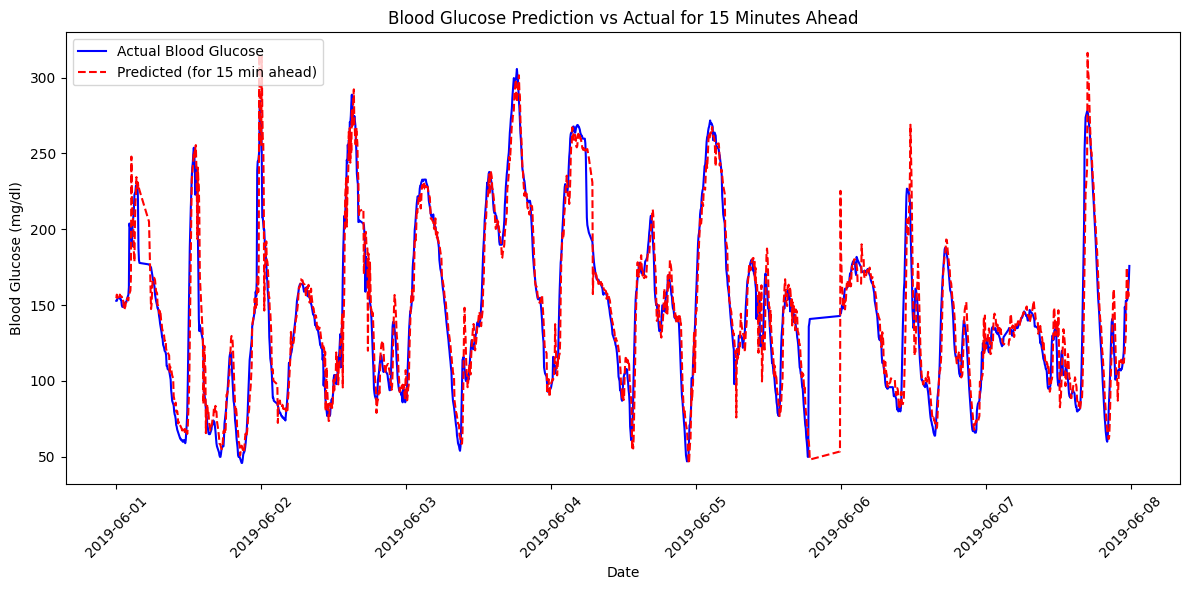

In [26]:
import matplotlib.pyplot as plt

# Function to make predictions for a specific week and plot them
def plot_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Predicted (for {target_step*5} min ahead)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Replace with desired dates
start_date = '2019-06-01'
end_date = '2019-06-08'
plot_predictions_for_week(cgm_data[train_size:], results['15 min ahead']['Model'], 3, start_date, end_date)


ARX Model with Blood Glucose and Bolus Data

In [28]:
# Load Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')

# Preprocess Bolus data - Round to nearest 5 minutes and fill missing values with 0
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge Bolus data with CGM data on date
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)  # Fill missing values after merge

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb', 'recommended.net']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaNs introduced by shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Update train/test split based on merged data
train_data = merged_data[:train_size]
test_data = merged_data[train_size:]

In [29]:
# Modify train_ar_model function to include all lagged features
def train_arx_model(data, target_step):
    # Prepare inputs (X) - using lag features from both mg/dl and Bolus data
    lag_columns = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
                  [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
    X = data[lag_columns].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Extract coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_

    # Display the coefficients
    print("Linear Regression Coefficients (ARX Model):")
    feature_names = merged_data.drop(columns=['date', 'mg/dl']).columns
    for feature, coef in zip(feature_names, coefficients):
      print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {intercept:.4f}")

    return model, rmse

In [30]:
# Modify train_arx_model function to include all lagged features
import matplotlib.pyplot as plt
import numpy as np

def train_arx_model(data, target_step):
    # Prepare inputs (X) - using lag features from both mg/dl and Bolus data
    lag_columns = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
                  [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
    X = data[lag_columns].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Extract coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_

    # Display the coefficients
    print("Linear Regression Coefficients (ARX Model):")
    feature_names = merged_data.drop(columns=['date', 'mg/dl']).columns
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {intercept:.4f}")

    # Generate a bar chart of coefficients
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]  # Sort by magnitude
    sorted_features = feature_names[sorted_indices]
    sorted_coefficients = coefficients[sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_features, sorted_coefficients, color='steelblue')
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Coefficient Magnitude', fontsize=12)
    plt.title('Linear Regression Coefficients (ARX Model)', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return model, rmse


Linear Regression Coefficients (ARX Model):
lag_1: 1.9701
lag_2: -0.5221
lag_3: -0.1963
lag_4: -0.1583
lag_5: -0.1193
lag_6: -0.0332
lag_7: -0.0294
lag_8: -0.0368
lag_9: 0.0626
lag_10: -0.0113
lag_11: -0.0054
lag_12: 0.0103
normal: 0.3806
carbInput: 0.1301
insulinCarbRatio: -0.1230
bgInput: -1.2015
recommended.carb: -2.1730
recommended.net: -2.0971
normal_lag_1: -2.0662
normal_lag_2: -1.5725
normal_lag_3: -1.0071
normal_lag_4: -0.6808
normal_lag_5: -0.4047
normal_lag_6: -0.4425
normal_lag_7: 10.4257
normal_lag_8: -8.2976
normal_lag_9: -5.0057
normal_lag_10: -4.1234
normal_lag_11: 0.5758
normal_lag_12: 11.8470
carbInput_lag_1: 16.5410
carbInput_lag_2: 19.2597
carbInput_lag_3: 13.2021
carbInput_lag_4: 5.2887
carbInput_lag_5: 3.7840
carbInput_lag_6: 2.8428
carbInput_lag_7: 0.5725
carbInput_lag_8: -1.0626
carbInput_lag_9: -0.3220
carbInput_lag_10: -0.3798
carbInput_lag_11: 0.1479
carbInput_lag_12: 1.2884
insulinCarbRatio_lag_1: 1.7077
insulinCarbRatio_lag_2: 1.9331
insulinCarbRatio_lag_3: 

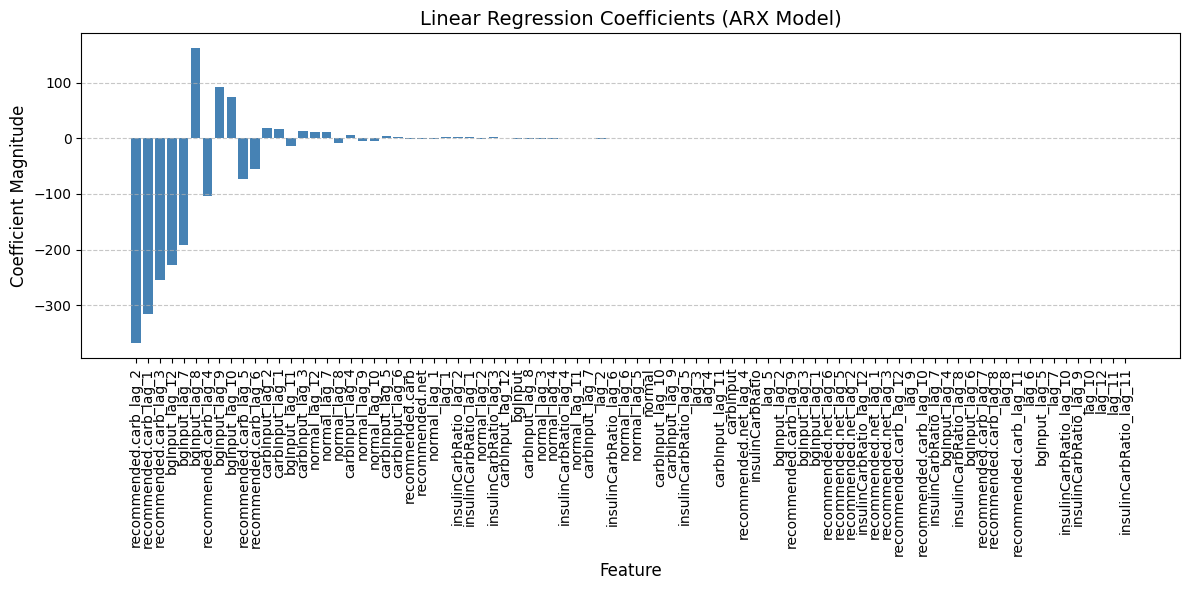

Time step 3 (predicting 15 minutes ahead) - ARX RMSE: 15.3533
Linear Regression Coefficients (ARX Model):
lag_1: 2.2878
lag_2: -0.7422
lag_3: -0.2859
lag_4: -0.2328
lag_5: -0.1277
lag_6: -0.0487
lag_7: -0.0275
lag_8: -0.0390
lag_9: 0.0819
lag_10: -0.0307
lag_11: 0.0266
lag_12: -0.0069
normal: -0.8291
carbInput: -1.4826
insulinCarbRatio: -1.9835
bgInput: -3.2023
recommended.carb: -3.9011
recommended.net: -3.4570
normal_lag_1: -3.0923
normal_lag_2: -2.4811
normal_lag_3: -1.6068
normal_lag_4: -1.1059
normal_lag_5: -0.5801
normal_lag_6: -0.6025
normal_lag_7: 8.3705
normal_lag_8: -6.5286
normal_lag_9: 5.6109
normal_lag_10: 9.4652
normal_lag_11: 14.2464
normal_lag_12: 23.6246
carbInput_lag_1: 27.2014
carbInput_lag_2: 25.9401
carbInput_lag_3: 19.2147
carbInput_lag_4: 10.4111
carbInput_lag_5: 7.1174
carbInput_lag_6: 0.7686
carbInput_lag_7: 0.3602
carbInput_lag_8: -0.8686
carbInput_lag_9: 0.7751
carbInput_lag_10: 1.0769
carbInput_lag_11: 1.6407
carbInput_lag_12: 2.5718
insulinCarbRatio_lag_1: 2

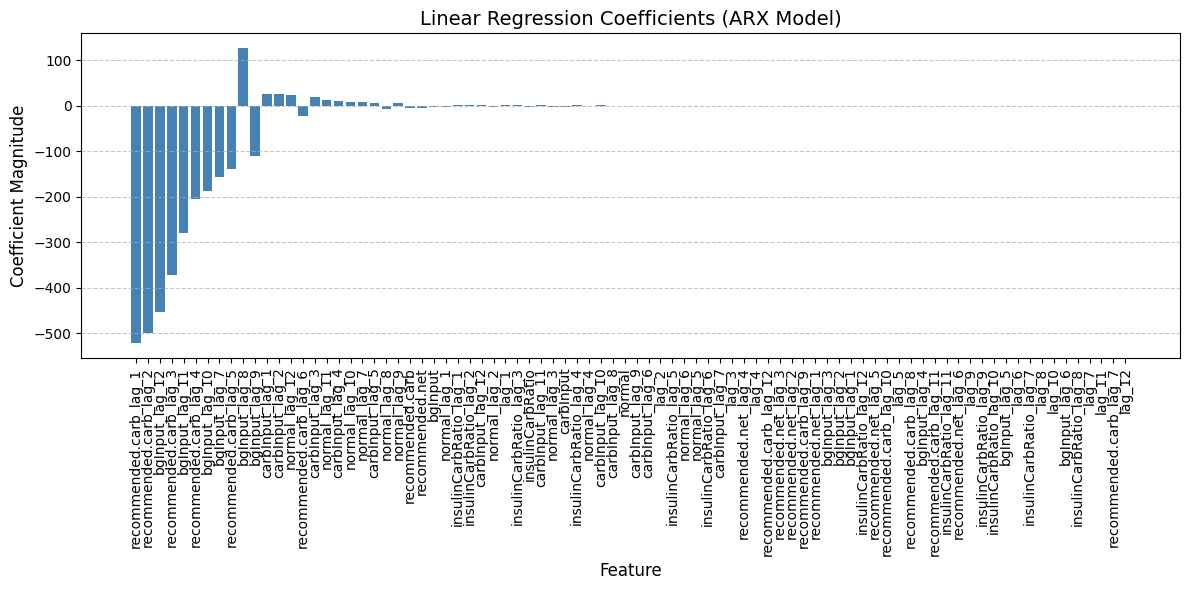

Time step 6 (predicting 30 minutes ahead) - ARX RMSE: 24.8168
Linear Regression Coefficients (ARX Model):
lag_1: 2.3124
lag_2: -0.7957
lag_3: -0.3288
lag_4: -0.2452
lag_5: -0.1356
lag_6: -0.0481
lag_7: -0.0444
lag_8: -0.0147
lag_9: 0.0864
lag_10: -0.0200
lag_11: 0.0277
lag_12: -0.0250
normal: -2.7723
carbInput: -3.0845
insulinCarbRatio: -3.3496
bgInput: -4.3135
recommended.carb: -4.9880
recommended.net: -4.2692
normal_lag_1: -3.6962
normal_lag_2: -2.7998
normal_lag_3: -1.8301
normal_lag_4: -1.1008
normal_lag_5: -0.4993
normal_lag_6: -0.3747
normal_lag_7: 22.0686
normal_lag_8: 6.4404
normal_lag_9: 16.2428
normal_lag_10: 19.1856
normal_lag_11: 20.6925
normal_lag_12: 31.3034
carbInput_lag_1: 34.8273
carbInput_lag_2: 30.8686
carbInput_lag_3: 18.5855
carbInput_lag_4: 6.4236
carbInput_lag_5: 1.8474
carbInput_lag_6: -5.5394
carbInput_lag_7: 1.8206
carbInput_lag_8: 0.5568
carbInput_lag_9: 1.9624
carbInput_lag_10: 2.1211
carbInput_lag_11: 2.3880
carbInput_lag_12: 3.5328
insulinCarbRatio_lag_1: 

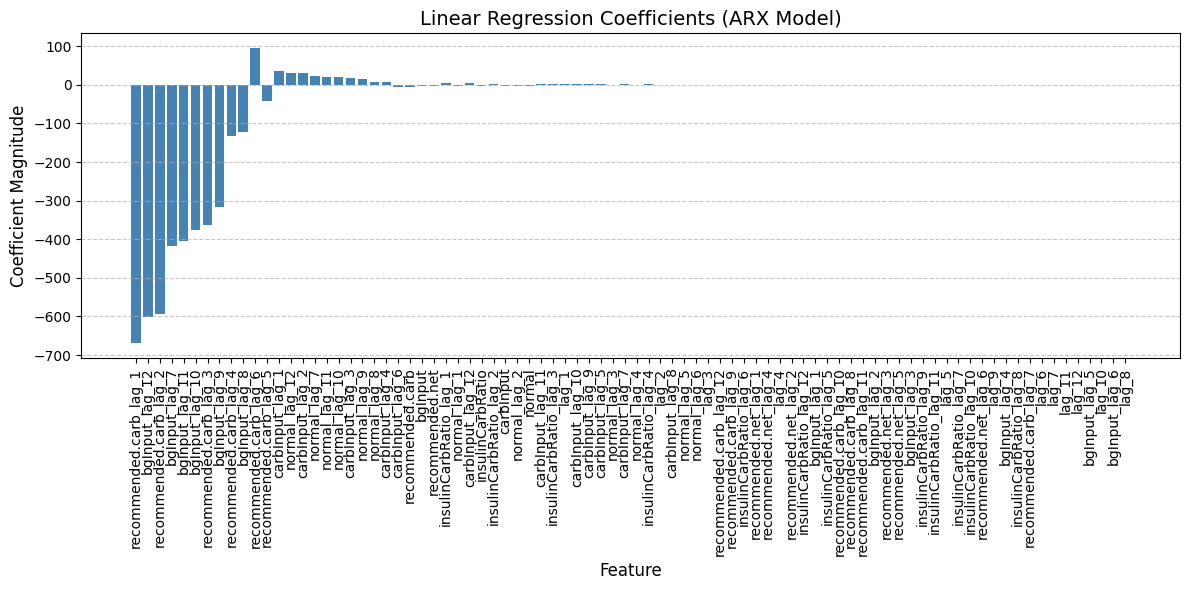

Time step 9 (predicting 45 minutes ahead) - ARX RMSE: 32.8597
Linear Regression Coefficients (ARX Model):
lag_1: 2.1965
lag_2: -0.7844
lag_3: -0.3268
lag_4: -0.2573
lag_5: -0.1056
lag_6: -0.0484
lag_7: -0.0284
lag_8: -0.0130
lag_9: 0.0730
lag_10: -0.0244
lag_11: 0.0075
lag_12: -0.0064
normal: -3.8665
carbInput: -4.1158
insulinCarbRatio: -4.1103
bgInput: -4.8340
recommended.carb: -5.2008
recommended.net: -4.3806
normal_lag_1: -3.5616
normal_lag_2: -2.6019
normal_lag_3: -1.5182
normal_lag_4: -0.5575
normal_lag_5: 0.2622
normal_lag_6: 0.7479
normal_lag_7: 30.8206
normal_lag_8: 12.8056
normal_lag_9: 23.5463
normal_lag_10: 26.7879
normal_lag_11: 25.7492
normal_lag_12: 30.7572
carbInput_lag_1: 30.7230
carbInput_lag_2: 24.9842
carbInput_lag_3: 11.9113
carbInput_lag_4: -0.8039
carbInput_lag_5: -3.6709
carbInput_lag_6: -8.2981
carbInput_lag_7: 2.8068
carbInput_lag_8: 1.3272
carbInput_lag_9: 2.8946
carbInput_lag_10: 3.0671
carbInput_lag_11: 3.0197
carbInput_lag_12: 3.5888
insulinCarbRatio_lag_1:

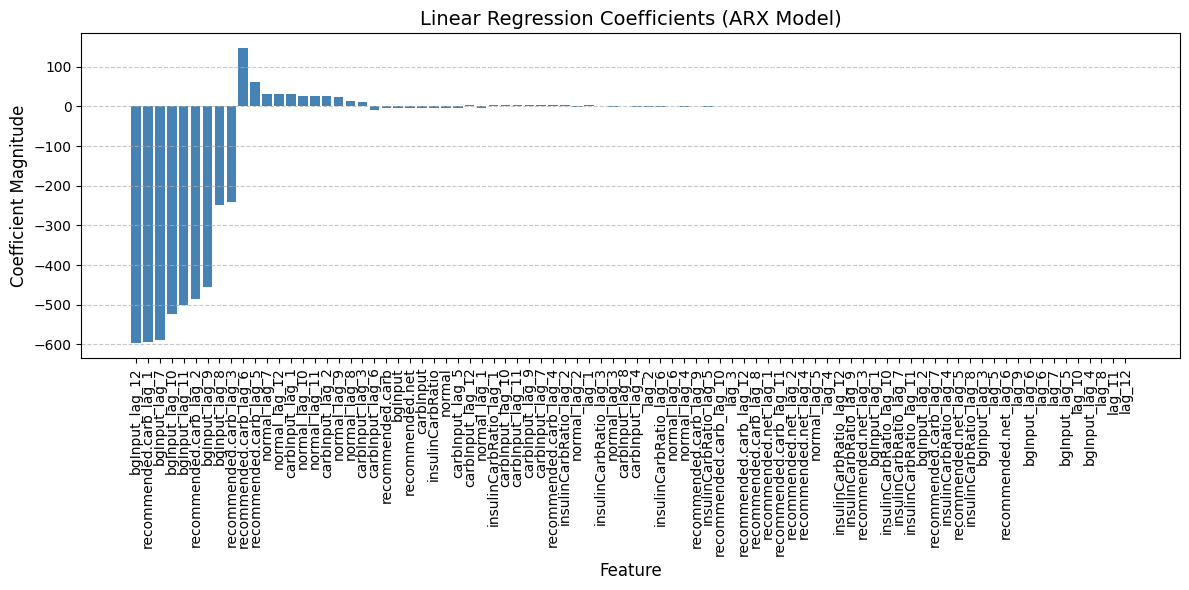

Time step 12 (predicting 60 minutes ahead) - ARX RMSE: 39.4085


In [31]:
# Train ARX models for different time steps and evaluate
results_arx = {}
for step in time_steps:
    model, rmse = train_arx_model(merged_data, step)
    results_arx[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Time step {step} (predicting {step*5} minutes ahead) - ARX RMSE: {rmse:.4f}")

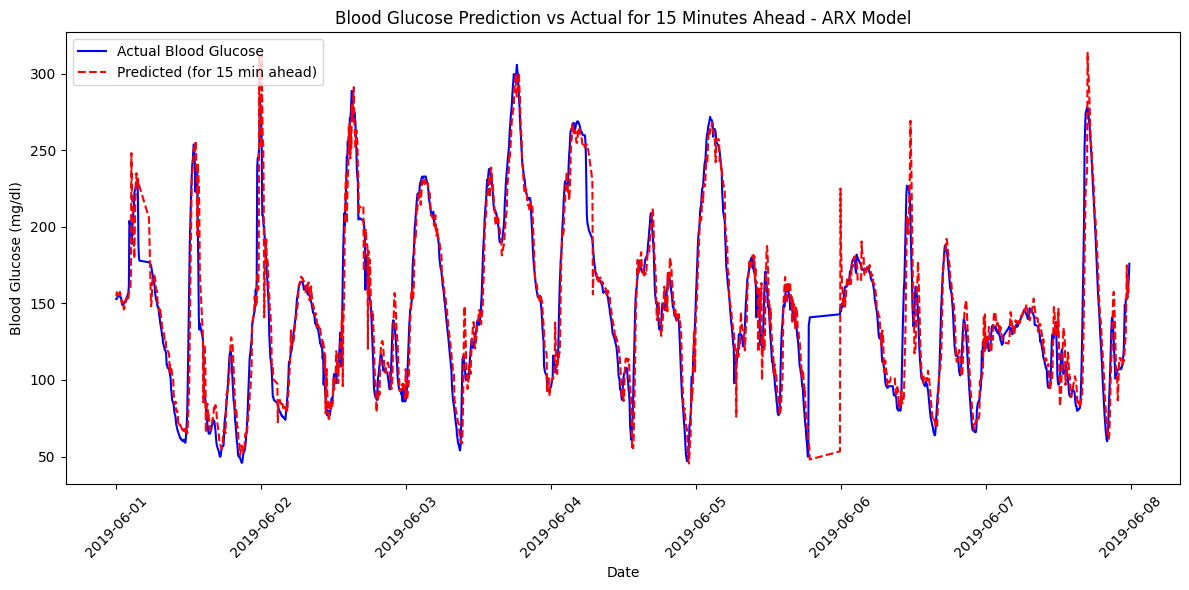

In [35]:
import matplotlib.pyplot as plt

# Function to make predictions for a specific week and plot them using the ARX model
def plot_predictions_for_week_arx(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction using lag features from both CGM and Bolus data
    lag_columns = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
                  [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
    X_week = week_data[lag_columns].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Predicted (for {target_step*5} min ahead)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead - ARX Model')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Replace with desired dates for plotting
start_date = '2019-06-01'
end_date = '2019-06-08'
plot_predictions_for_week_arx(merged_data[train_size:], results_arx['15 min ahead']['Model'], 3, start_date, end_date)


ARX with Bolus and Basal

In [60]:
# Load and preprocess Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)

# Load and preprocess Basal data
basal_data = pd.read_excel(file_path, sheet_name='Basal')
basal_data['date'] = pd.to_datetime(basal_data['date']).dt.round('5min')

# Create a complete 5-minute timestamp range for forward filling
full_time_range = pd.DataFrame({'date': pd.date_range(start=cgm_data['date'].min(),
                                                      end=cgm_data['date'].max(),
                                                      freq='5min')})

# Merge with full time range and forward fill missing values
basal_data = pd.merge(full_time_range, basal_data, on='date', how='left')
basal_data = basal_data.fillna(method='ffill')  # Forward fill sparse data

# Merge Bolus and Basal data with CGM data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)
merged_data = pd.merge(merged_data, basal_data, on='date', how='left').fillna(0)

<ipython-input-60-58cd9b3d65a3>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  basal_data = basal_data.fillna(method='ffill')  # Forward fill sparse data


In [61]:
# Define variables for lag features
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb', 'recommended.net']
basal_vars = ['rate', 'duration']

# Generate lag features for Bolus and Basal data
for var in bolus_vars + basal_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaNs introduced by shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Train/test split
train_size = int(0.8 * len(merged_data))
train_data = merged_data[:train_size]
test_data = merged_data[train_size:]

In [64]:
# Train ARX Model
def train_arx_model(data, target_step):
    lag_columns = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
                  [f'{var}_lag_{i}' for var in bolus_vars + basal_vars for i in range(1, num_lags + 1)]
    X = data[lag_columns].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Display coefficients
    coefficients = model.coef_
    intercept = model.intercept_

    print("Linear Regression Coefficients (ARX Model):")
    feature_names = merged_data.drop(columns=['date', 'mg/dl']).columns
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {intercept:.4f}")

    return model, rmse

# Train for different time steps
time_steps = [3, 6, 9, 12]  # Example time steps (15, 30, 45, 60 min ahead)
results_arx = {}
for step in time_steps:
    model, rmse = train_arx_model(merged_data, step)
    results_arx[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Time step {step} (predicting {step*5} minutes ahead) - ARX RMSE: {rmse:.4f}")

Linear Regression Coefficients (ARX Model):
lag_1: 1.9645
lag_2: -0.5181
lag_3: -0.1976
lag_4: -0.1577
lag_5: -0.1186
lag_6: -0.0318
lag_7: -0.0264
lag_8: -0.0352
lag_9: 0.0592
lag_10: -0.0054
lag_11: -0.0100
lag_12: 0.0113
normal: 0.3272
carbInput: 0.1480
insulinCarbRatio: -0.1018
bgInput: -1.1282
recommended.carb: -1.8280
recommended.net: -1.7911
duration: -1.7705
rate: -1.2717
normal_lag_1: -0.8747
normal_lag_2: -0.4795
normal_lag_3: -0.2502
normal_lag_4: -0.2794
normal_lag_5: -0.2547
normal_lag_6: 0.7022
normal_lag_7: 0.0352
normal_lag_8: -0.0697
normal_lag_9: -0.2971
normal_lag_10: -0.7144
normal_lag_11: -0.9420
normal_lag_12: -1.1339
carbInput_lag_1: -0.9042
carbInput_lag_2: -0.5104
carbInput_lag_3: -0.3970
carbInput_lag_4: -0.3005
carbInput_lag_5: 0.4186
carbInput_lag_6: -1.1370
carbInput_lag_7: -0.2165
carbInput_lag_8: -0.3463
carbInput_lag_9: 0.0978
carbInput_lag_10: 0.9983
carbInput_lag_11: 1.3951
carbInput_lag_12: 1.6479
insulinCarbRatio_lag_1: 1.2659
insulinCarbRatio_lag_2:

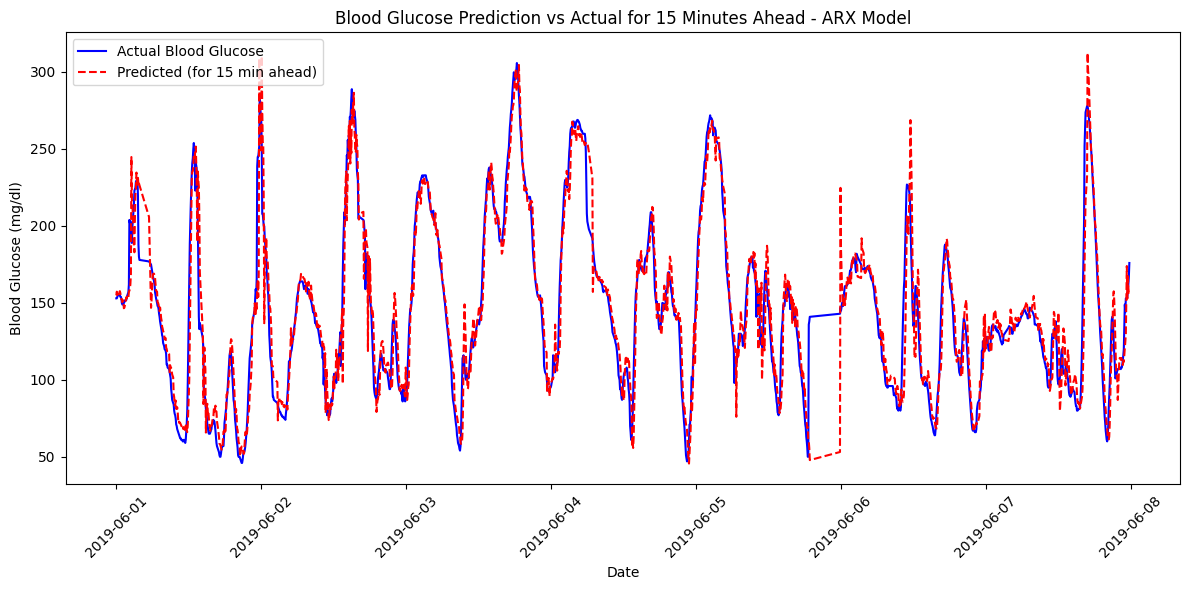

In [69]:
import matplotlib.pyplot as plt

def plot_predictions_for_week_arx(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction using lag features from both CGM and Bolus data
    # Include lag features for Basal variables as well
    lag_columns = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
                  [f'{var}_lag_{i}' for var in bolus_vars + basal_vars for i in range(1, num_lags + 1)]
    X_week = week_data[lag_columns].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Predicted (for {target_step*5} min ahead)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead - ARX Model')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Replace with desired dates for plotting
start_date = '2019-06-01'
end_date = '2019-06-08'
plot_predictions_for_week_arx(merged_data[train_size:], results_arx['15 min ahead']['Model'], 3, start_date, end_date)


Recursive AR Model

In [ ]:
# Recursive forecasting function for the AR model
def recursive_forecast_ar_model(data, model, num_steps):
    # Initialize a list to store predictions
    predictions = []

    # Get the last 'num_lags' lag values from the data for initial input
    last_known_data = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].iloc[-1].values

    # Generate recursive predictions
    for _ in range(num_steps):
        # Reshape last known data to fit model input format
        next_input = last_known_data.reshape(1, -1)

        # Predict the next step
        next_pred = model.predict(next_input)[0]
        predictions.append(next_pred)

        # Update the input data by adding the new prediction and dropping the oldest value
        last_known_data = np.roll(last_known_data, -1)  # Shift values left
        last_known_data[-1] = next_pred  # Add new prediction as the latest lag

    return predictions

In [ ]:
# Function to train the AR model on 1-step-ahead predictions
def train_single_step_ar_model(data):
    # Prepare inputs (X) and target (y) for single step
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-1).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test set (1-step-ahead for evaluation)
    y_pred = model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return model, rmse

In [ ]:
# Train the single-step AR model and evaluate
single_step_model, single_step_rmse = train_single_step_ar_model(cgm_data)
print(f"Single-step prediction model - RMSE: {single_step_rmse:.4f}")

# Perform recursive forecasting for different time steps
future_steps = [3, 6, 9, 12]  # 15, 30, 45, 60 minutes ahead
recursive_results = {}

for step in future_steps:
    # Recursive prediction
    predictions = recursive_forecast_ar_model(cgm_data, single_step_model, step)
    recursive_results[f'{step*5} min ahead'] = predictions
    print(f"Recursive prediction for {step*5} minutes ahead: {predictions}")

Single-step prediction model - RMSE: 10.6876
Recursive prediction for 15 minutes ahead: [126.17805109733817, 127.68015956863383, 120.76163207918681]
Recursive prediction for 30 minutes ahead: [126.17805109733817, 127.68015956863383, 120.76163207918681, 109.52853483526249, 109.00482971243424, 128.98632079699058]
Recursive prediction for 45 minutes ahead: [126.17805109733817, 127.68015956863383, 120.76163207918681, 109.52853483526249, 109.00482971243424, 128.98632079699058, 152.45971484822644, 162.17968482857108, 128.94240587123528]
Recursive prediction for 60 minutes ahead: [126.17805109733817, 127.68015956863383, 120.76163207918681, 109.52853483526249, 109.00482971243424, 128.98632079699058, 152.45971484822644, 162.17968482857108, 128.94240587123528, 138.44187680436852, 124.718144110842, 138.22606406267354]


In [ ]:
from sklearn.metrics import mean_squared_error

# Function to calculate RMSE for each recursive forecast
def calculate_recursive_rmse(data, model, num_steps):
    # Initialize list to store RMSE values
    rmse_values = {}

    # Iterate through each time step to calculate RMSE
    for step in num_steps:
        # Get the recursive predictions for the current step
        predictions = recursive_forecast_ar_model(data, model, step)

        # Get the actual values corresponding to this step
        actual_values = data['mg/dl'].shift(-step).dropna().values[:len(predictions)]

        # Calculate RMSE for this time step
        rmse = np.sqrt(mean_squared_error(actual_values, predictions))
        rmse_values[f'{step*5} min ahead'] = rmse
        print(f"RMSE for recursive forecast {step*5} minutes ahead: {rmse:.4f}")

    return rmse_values

# Calculate RMSE for recursive forecasts on the test set
recursive_rmse = calculate_recursive_rmse(cgm_data[train_size:], single_step_model, future_steps)


RMSE for recursive forecast 15 minutes ahead: 26.7744
RMSE for recursive forecast 30 minutes ahead: 38.2271
RMSE for recursive forecast 45 minutes ahead: 30.4010
RMSE for recursive forecast 60 minutes ahead: 29.9050


LASSO Regression

In [ ]:
from sklearn.linear_model import Lasso

# Function to train and evaluate a Lasso regression model for a specified prediction step
def train_lasso_model(data, target_step, alpha=0.1, max_iter=5000):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the Lasso model with specified alpha (regularization strength)
    lasso_model = Lasso(alpha=alpha, max_iter=max_iter)
    lasso_model.fit(X_train, y_train)

    # Make predictions
    y_pred = lasso_model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return lasso_model, rmse

In [ ]:
# Train and evaluate Lasso models for different time steps
lasso_results = {}
for step in time_steps:
    model, rmse = train_lasso_model(cgm_data, step, alpha=0.1, max_iter=5000)
    lasso_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Lasso regression for {step*5} minutes ahead - RMSE: {rmse:.4f}")

Lasso regression for 15 minutes ahead - RMSE: 18.8339
Lasso regression for 30 minutes ahead - RMSE: 28.8946
Lasso regression for 45 minutes ahead - RMSE: 36.9436
Lasso regression for 60 minutes ahead - RMSE: 43.2089


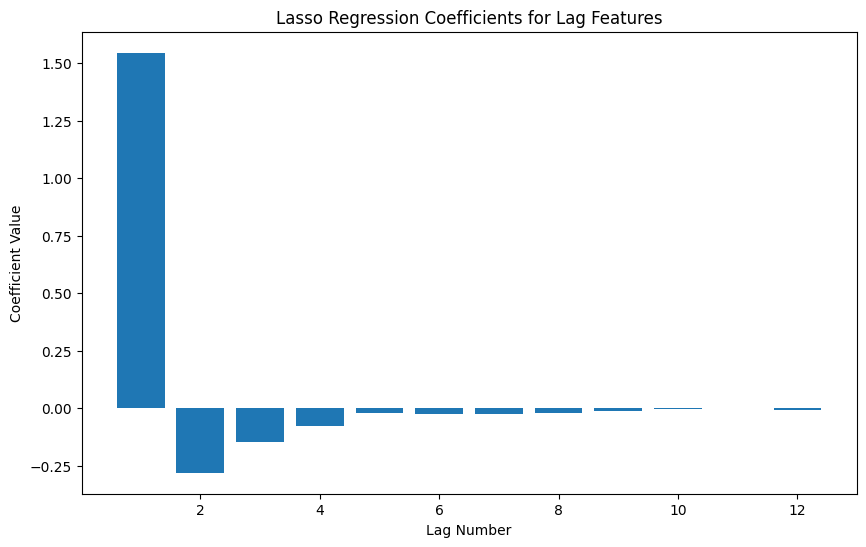

In [ ]:
# Optional: Visualize the coefficients
import matplotlib.pyplot as plt

def plot_lasso_coefficients(model, num_lags):
    coefficients = model.coef_
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, num_lags + 1), coefficients)
    plt.xlabel('Lag Number')
    plt.ylabel('Coefficient Value')
    plt.title('Lasso Regression Coefficients for Lag Features')
    plt.show()

# Plot Lasso coefficients for one of the models
plot_lasso_coefficients(lasso_results['15 min ahead']['Model'], num_lags)

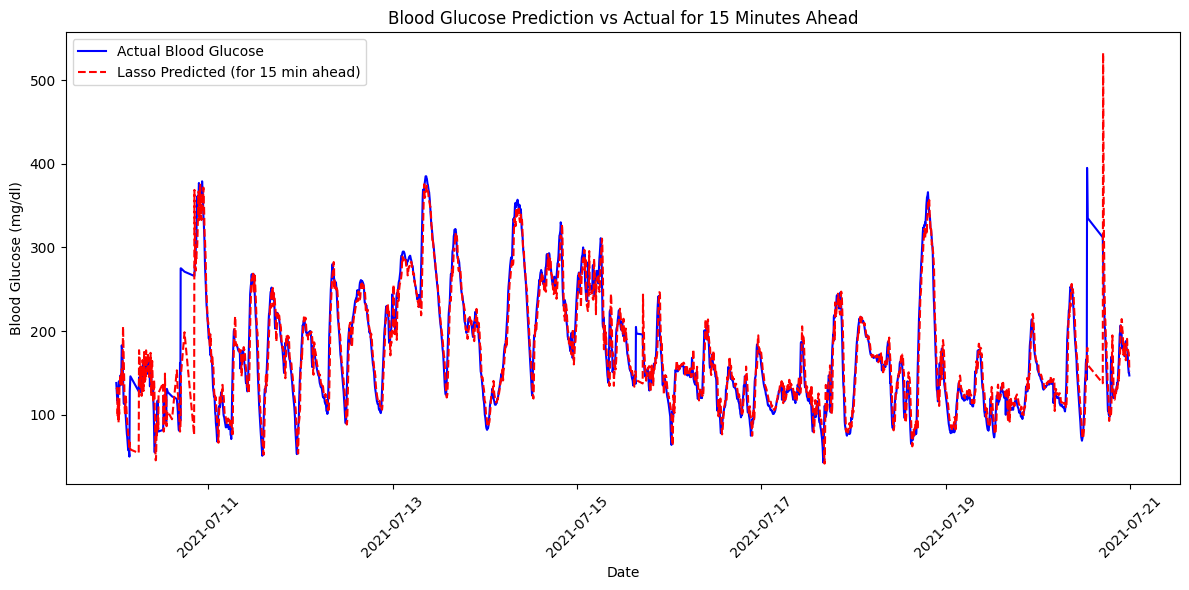

In [ ]:
import matplotlib.pyplot as plt

# Function to make predictions for a specific week and plot them
def plot_lasso_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Lasso Predicted (for {target_step*5} min ahead)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with Lasso model and specific date range
start_date = '2021-07-10'
end_date = '2021-07-21'
plot_lasso_predictions_for_week(cgm_data[train_size:], lasso_results['15 min ahead']['Model'], 3, start_date, end_date)


Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

# Function to train and evaluate a Ridge regression model for a specified prediction step
def train_ridge_model(data, target_step, alpha=1.0):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the Ridge model with specified alpha (regularization strength)
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)

    # Make predictions
    y_pred = ridge_model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return ridge_model, rmse

# Train and evaluate Ridge models for different time steps
ridge_results = {}
alpha_value = 1.0  # Adjust alpha as needed for regularization strength
for step in time_steps:
    model, rmse = train_ridge_model(cgm_data, step, alpha=alpha_value)
    ridge_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Ridge regression for {step*5} minutes ahead - RMSE: {rmse:.4f}")


Ridge regression for 15 minutes ahead - RMSE: 18.8309
Ridge regression for 30 minutes ahead - RMSE: 28.8924
Ridge regression for 45 minutes ahead - RMSE: 36.9419
Ridge regression for 60 minutes ahead - RMSE: 43.2075


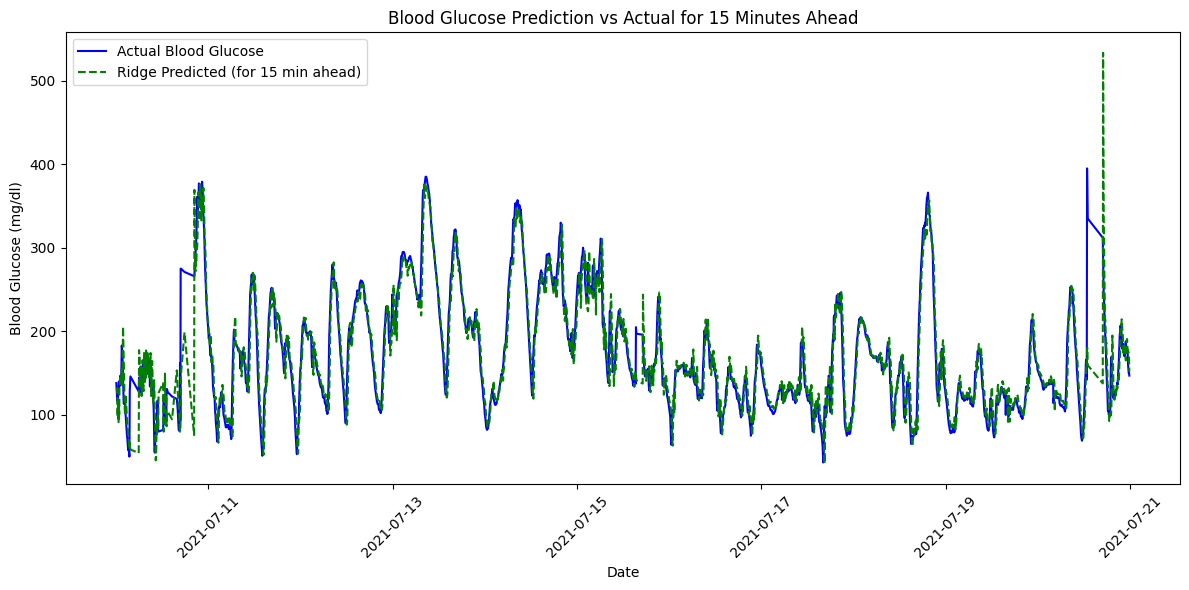

In [ ]:
# Function to make predictions for a specific week and plot them using Ridge model
def plot_ridge_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Ridge Predicted (for {target_step*5} min ahead)', color='green', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with Ridge model and specific date range
start_date = '2021-07-10'
end_date = '2021-07-21'
plot_ridge_predictions_for_week(cgm_data[train_size:], ridge_results['15 min ahead']['Model'], 3, start_date, end_date)


Elastic Net Regression

In [ ]:
from sklearn.linear_model import ElasticNet

# Function to train and evaluate ElasticNet model
def train_elastic_net_model(data, target_step, alpha=1.0, l1_ratio=0.5):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the ElasticNet model
    elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elastic_net_model.fit(X_train, y_train)

    # Make predictions
    y_pred = elastic_net_model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return elastic_net_model, rmse

# Train and evaluate ElasticNet models for different time steps
elastic_net_results = {}
alpha_value = 1.0  # Regularization strength (larger values => more regularization)
l1_ratio_value = 0.5  # Mix ratio between Lasso (L1) and Ridge (L2) regularization
for step in time_steps:
    model, rmse = train_elastic_net_model(cgm_data, step, alpha=alpha_value, l1_ratio=l1_ratio_value)
    elastic_net_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"ElasticNet for {step*5} minutes ahead - RMSE: {rmse:.4f}")


ElasticNet for 15 minutes ahead - RMSE: 18.8572
ElasticNet for 30 minutes ahead - RMSE: 28.9136
ElasticNet for 45 minutes ahead - RMSE: 36.9584
ElasticNet for 60 minutes ahead - RMSE: 43.2202


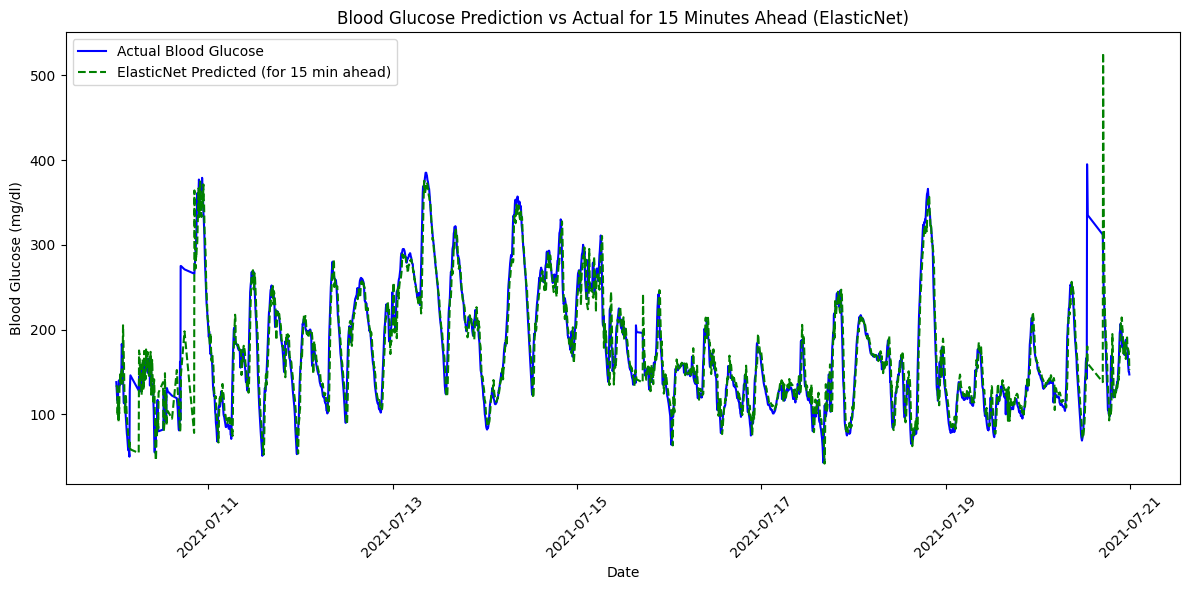

In [ ]:
# Function to plot ElasticNet predictions for a specific week
def plot_elastic_net_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'ElasticNet Predicted (for {target_step*5} min ahead)', color='green', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead (ElasticNet)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with ElasticNet model and specific date range
start_date = '2021-07-10'
end_date = '2021-07-21'
plot_elastic_net_predictions_for_week(cgm_data[train_size:], elastic_net_results['15 min ahead']['Model'], 3, start_date, end_date)


Huber

In [ ]:
from sklearn.linear_model import HuberRegressor

# Function to train and evaluate Huber regression model
def train_huber_model(data, target_step, epsilon=1.35):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the Huber regression model
    huber_model = HuberRegressor(epsilon=epsilon, max_iter=1000)
    huber_model.fit(X_train, y_train)

    # Make predictions
    y_pred = huber_model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return huber_model, rmse

# Train and evaluate Huber models for different time steps
huber_results = {}
epsilon_value = 1.35  # Huber loss function parameter (controls the threshold between quadratic and linear loss)
for step in time_steps:
    model, rmse = train_huber_model(cgm_data, step, epsilon=epsilon_value)
    huber_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Huber for {step*5} minutes ahead - RMSE: {rmse:.4f}")


Huber for 15 minutes ahead - RMSE: 18.7570
Huber for 30 minutes ahead - RMSE: 29.0361
Huber for 45 minutes ahead - RMSE: 37.2799
Huber for 60 minutes ahead - RMSE: 43.6411


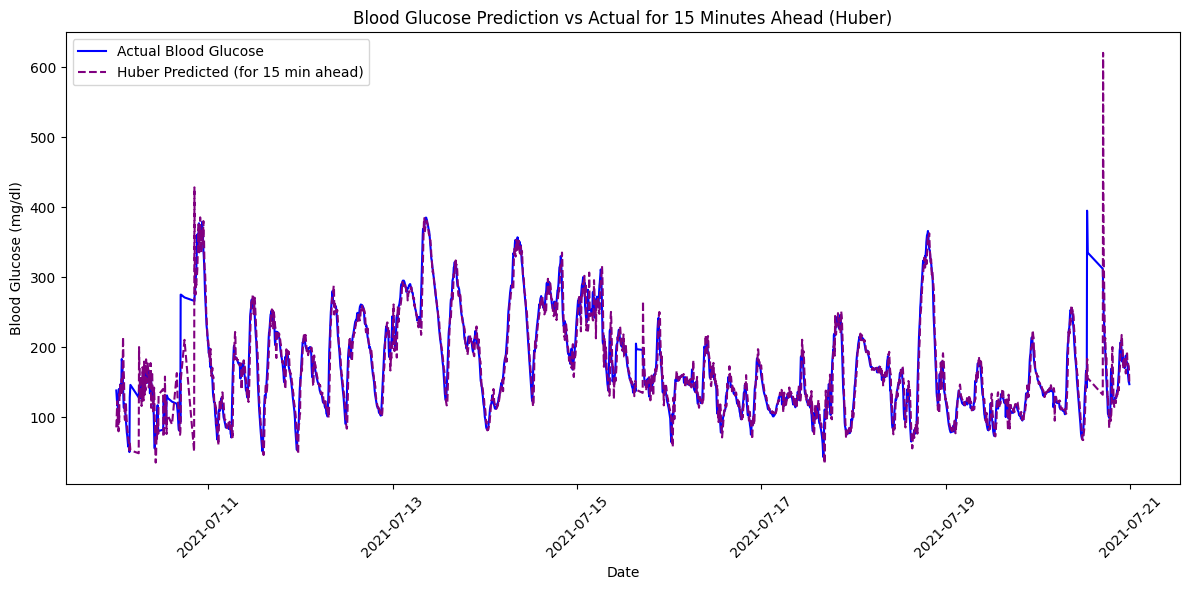

In [ ]:
# Function to plot Huber predictions for a specific week
def plot_huber_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Huber Predicted (for {target_step*5} min ahead)', color='purple', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead (Huber)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with Huber model and specific date range
start_date = '2021-07-10'
end_date = '2021-07-21'
plot_huber_predictions_for_week(cgm_data[train_size:], huber_results['15 min ahead']['Model'], 3, start_date, end_date)


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Function to train and evaluate Random Forest model
def train_rf_model(data, target_step, n_estimators=100, max_depth=None, random_state=42):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rf_model, rmse

# Train and evaluate Random Forest models for different time steps
rf_results = {}
for step in time_steps:
    model, rmse = train_rf_model(cgm_data, step, n_estimators=100, max_depth=10)
    rf_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Random Forest for {step*5} minutes ahead - RMSE: {rmse:.4f}")


Random Forest for 15 minutes ahead - RMSE: 18.0192
Random Forest for 30 minutes ahead - RMSE: 27.7374
Random Forest for 45 minutes ahead - RMSE: 35.6545
Random Forest for 60 minutes ahead - RMSE: 41.9177


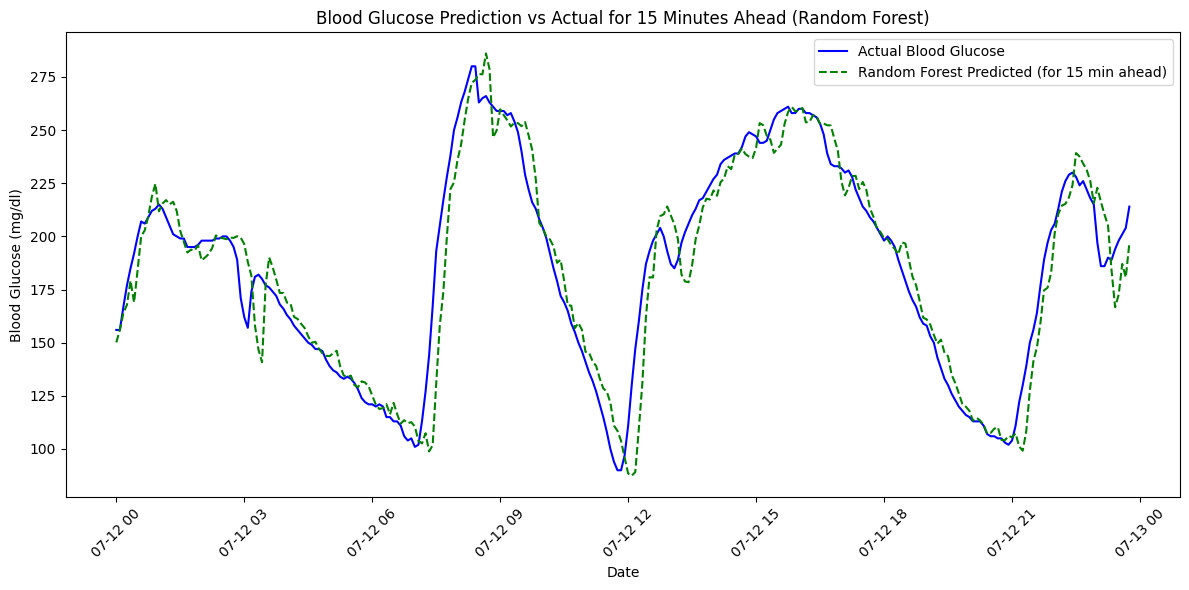

In [ ]:
# Function to plot Random Forest predictions for a specific week
def plot_rf_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Random Forest Predicted (for {target_step*5} min ahead)', color='green', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead (Random Forest)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with Random Forest model and specific date range
start_date = '2021-07-12'
end_date = '2021-07-13'
plot_rf_predictions_for_week(cgm_data[train_size:], rf_results['15 min ahead']['Model'], 3, start_date, end_date)


XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Function to train and evaluate XGBoost model
def train_xgb_model(data, target_step, num_boost_round=100, learning_rate=0.1, max_depth=30, random_state=42):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set parameters for XGBoost
    params = {
        'objective': 'reg:squarederror',  # Regression task (squared error loss)
        'eval_metric': 'rmse',            # Metric to evaluate model
        'max_depth': max_depth,           # Depth of the trees
        'learning_rate': learning_rate,  # Step size shrinkage
        'random_state': random_state,    # For reproducibility
    }

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Make predictions
    y_pred = model.predict(dtest)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return model, rmse

# Train and evaluate XGBoost models for different time steps
xgb_results = {}
for step in time_steps:
    model, rmse = train_xgb_model(cgm_data, step, num_boost_round=100, learning_rate=0.1, max_depth=10)
    xgb_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"XGBoost for {step*5} minutes ahead - RMSE: {rmse:.4f}")


XGBoost for 15 minutes ahead - RMSE: 17.8230
XGBoost for 30 minutes ahead - RMSE: 27.5559
XGBoost for 45 minutes ahead - RMSE: 35.5219
XGBoost for 60 minutes ahead - RMSE: 41.8985


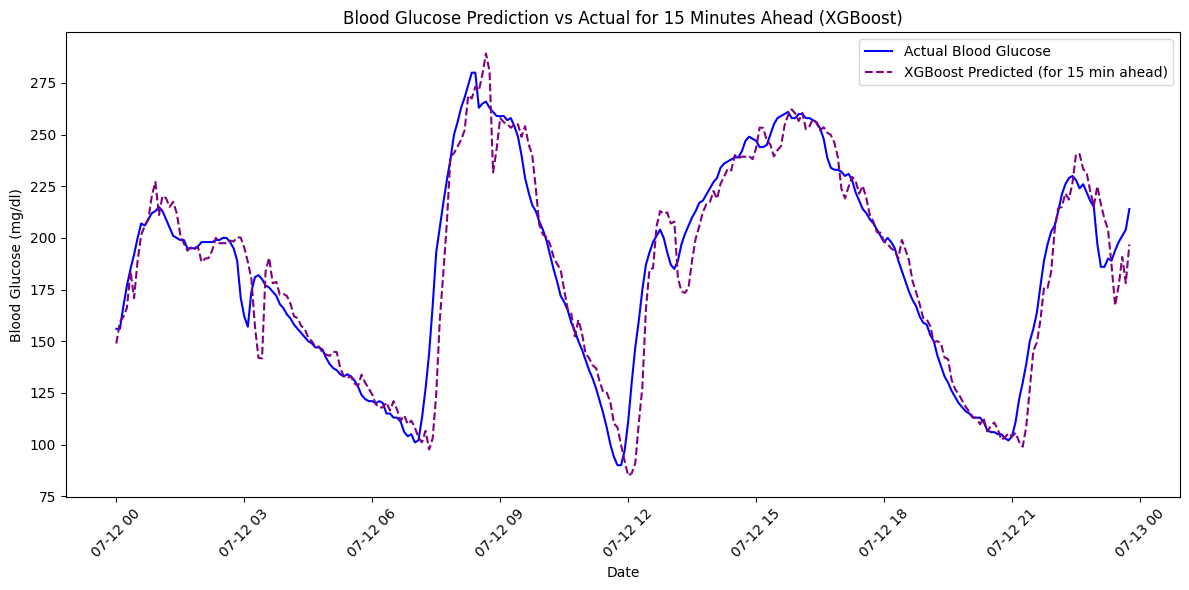

In [ ]:
# Function to plot XGBoost predictions for a specific week
def plot_xgb_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(xgb.DMatrix(X_week))

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'XGBoost Predicted (for {target_step*5} min ahead)', color='purple', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead (XGBoost)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with XGBoost model and specific date range
start_date = '2021-07-12'
end_date = '2021-07-13'
plot_xgb_predictions_for_week(cgm_data[train_size:], xgb_results['15 min ahead']['Model'], 3, start_date, end_date)


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to train and evaluate XGBoost model with ARX features
def train_xgb_arx_model(data, target_step, num_boost_round=100, learning_rate=0.1, max_depth=10, random_state=42):
    # Prepare inputs (X) and target (y)
    # Use all lagged features (CGM + Bolus variables)
    feature_columns = [col for col in data.columns if col.startswith('lag_') or '_lag_' in col]
    X = data[feature_columns].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set parameters for XGBoost
    params = {
        'objective': 'reg:squarederror',  # Regression task (squared error loss)
        'eval_metric': 'rmse',            # Metric to evaluate model
        'max_depth': max_depth,           # Depth of the trees
        'learning_rate': learning_rate,   # Step size shrinkage
        'random_state': random_state,     # For reproducibility
    }

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Make predictions
    y_pred = model.predict(dtest)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return model, rmse

# Train and evaluate XGBoost models for different time steps
xgb_arx_results = {}
for step in time_steps:
    model, rmse = train_xgb_arx_model(merged_data, step, num_boost_round=100, learning_rate=0.1, max_depth=10)
    xgb_arx_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"XGBoost (ARX) for {step*5} minutes ahead - RMSE: {rmse:.4f}")

XGBoost (ARX) for 15 minutes ahead - RMSE: 17.8321
XGBoost (ARX) for 30 minutes ahead - RMSE: 27.5621
XGBoost (ARX) for 45 minutes ahead - RMSE: 35.5331
XGBoost (ARX) for 60 minutes ahead - RMSE: 41.9025
